# Augmented _Gradients_ Transect Data

Here we (1) retrieve [SCOPE-Gradients](http://scope.soest.hawaii.edu/data/gradients/data/) cruise data from the [Simons' CMAP](https://cmap.readthedocs.io/en/latest/) data base and (2) collocate with mean dymanic topography / SSH.

<img src="cbiomes-01.png" alt="Drawing" style="height: 150px;"/>

### Set up tools

[PyCmap](https://github.com/simonscmap/pycmap) is the Python API that we will use in Julia, via [PyCall.jl](https://github.com/JuliaPy/PyCall.jl), to query the CMAP data base. [Plots.jl](http://docs.juliaplots.org/latest/) is a common `Julia` plotting package and `helper_functions.jl` adds a few convenience functions.

_Pre-requisites:_

- 1. _install the [PyCmap](https://github.com/simonscmap/pycmap) python package and its dependencies using `pip`_
- 2. _compile [PyCall.jl](https://github.com/simonscmap/pycmap) using external python distribution that installed `PyCmap`_
- 3. _obtain your own API key from [Simons' CMAP](https://simonscmap.com) (free; takes `<30s`)_
- 4. _import `pycmap` (via `pycall`), `Plots`, and `helper functions`_

_You may need to replace `your-own-API-key` (as outline below) with your own API key from [Simons' CMAP](https://simonscmap.com) and uncomment the command below._

In [1]:
if false
    run(`pip install pycmap`) #pycmap is used via PyCall later
    run(pipeline(`which python`,"whichpython.txt")) #external python path
    ENV["PYTHON"]=readline("whichpython.txt")
    import Pkg; Pkg.build("PyCall")
end

In [2]:
using PyCall
PyCmap = pyimport("pycmap")
#cmap = PyCmap.API(token="your-own-API-key")
cmap = PyCmap.API()

using Plots
include("helper_functions.jl")

┌ Info: Precompiling MeshArrays [cb8c808f-1acf-59a3-9d2b-6e38d009f683]
└ @ Base loading.jl:1273
┌ Info: Precompiling MITgcmTools [62725fbc-3a66-4df3-9000-e33e85b3a198]
└ @ Base loading.jl:1273


Main.cbiomes_helpers

### Get Data Catalog

_Downloading the catalog is a simple way to verify that cmap is all set-up. The commented `df.to_csv` command writes the content of `df` to a new `catalog.csv` file. Alternatively, `Pandas.jl` can be used as also shown._

In [3]:
df = cmap.get_catalog();
#df.to_csv("catalog.csv")

#df=Pandas.DataFrame(cmap.get_catalog());
#to_csv(df,"catalog.csv")

### Download Data (`.csv` Files)

A simple method is to download data from `CMAP` and store it to a `CSV` file which any software can then reload. Below, `cmap_helpers.tables` provide CMAP `table` lists for [SCOPE-Gradients](http://scope.soest.hawaii.edu/data/gradients/data/) cruise data, which `cmap.get_dataset` downloads one at a time. _Alternatively one can use the computer's memory (later slides)._

In [4]:
pth="../samples/gradients/"
!isdir("$pth") ? mkdir("$pth") : nothing

Γ=1:3
γ=filter(x -> occursin("tblKM1906",x), readdir(pth))
!isempty(γ) ? Γ = [] : nothing

for g in Γ
    list0=cmap_helpers.tables("G$g")
    for i in list0
        df=cmap.get_dataset(i)
        df.to_csv("$pth$i.csv")
    end
end

### Read Data (& Meta-Data)

As an example below we read, and then plot, the `LISST` data collected during the `Gradients 3` cruise.

In [5]:
s=cmap_helpers.get("tblKM1906_Gradients3_uway_optics","LISST_small")
m=cmap_helpers.get("tblKM1906_Gradients3_uway_optics","LISST_medium")
l=cmap_helpers.get("tblKM1906_Gradients3_uway_optics","LISST_large")

Dict{String,Any} with 8 entries:
  "Long_Name"   => "LISST C 20-100.0 micron"
  "Unit"        => "umol C/L"
  "lat"         => [21.2464, 21.2464, 21.2464, 21.2464, 21.2465, 21.2465, 21.24…
  "time"        => ["2019-04-10T00:39:37", "2019-04-10T00:42:07", "2019-04-10T0…
  "Variable"    => "LISST_large"
  "val"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, N…
  "lon"         => [-158.034, -158.037, -158.041, -158.045, -158.048, -158.052,…
  "Data_Source" => "Prof. Dr. Angelicque A. White, University of Hawaii, aewhit…

### Collocate Ancillary Data

Here we interpolate a `sea surface height` climatology estimate ([Forget et al 2015](http://doi.org/10.5194/gmd-8-3071-2015)) along the ship track. _Any number of commonly available methods can readily be used to interpolate gridded estimates to observed locations. For `MITgcm` output in our example, we use `MeshArrays.jl` method._

In [6]:
ssh=cbiomes_helpers.myinterp(pth,"SSH",s["lon"],s["lat"])
ssh=merge(ssh,Dict("Unit" => "m", "Variable" => "SSH", "Long_Name" => "Sea Surface Height (Mean Dynamic Topography)"))

Dict{String,Any} with 7 entries:
  "lat"         => [21.2464, 21.2464, 21.2464, 21.2464, 21.2465, 21.2465, 21.24…
  "Long_Name"   => "Sea Surface Height (Mean Dynamic Topography)"
  "Unit"        => "m"
  "Variable"    => "SSH"
  "val"         => [0.701766, 0.701738, 0.70171, 0.70168, 0.70165, 0.701618, 0.…
  "lon"         => [-158.034, -158.037, -158.041, -158.045, -158.048, -158.052,…
  "Data_Source" => "ECCOv4r2 (Gael Forget)"

### Plot v Latitude

 LISST data collected in Gradients 3 and the sea surface height climatology.

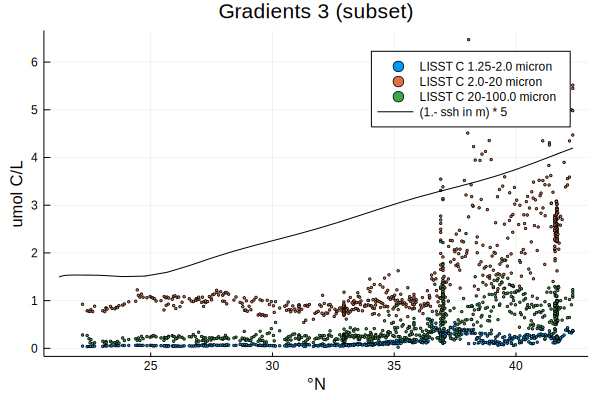

In [7]:
t=1:10:length(s["lat"])
scatter(s["lat"][t],s["val"][t],marker = 1.5,label=s["Long_Name"],
    xlabel="°N",ylabel=s["Unit"], title="Gradients 3 (subset)")
scatter!(m["lat"][t],m["val"][t],marker = 1.5,label=m["Long_Name"])
scatter!(l["lat"][t],l["val"][t],marker = 1.5,label=l["Long_Name"])
plot!(ssh["lat"][t],(1.0.-ssh["val"][t]).*5.0,linecolor=:black,label="(1.- ssh in m) * 5")

### Gradients As Function Of Station ID

`Gradients1`, `Gradients2`, and `Gradients3` are plotted one after the other. _Note the strong covariations, in each case, with the ship moving back and forth across the gyre in each case._

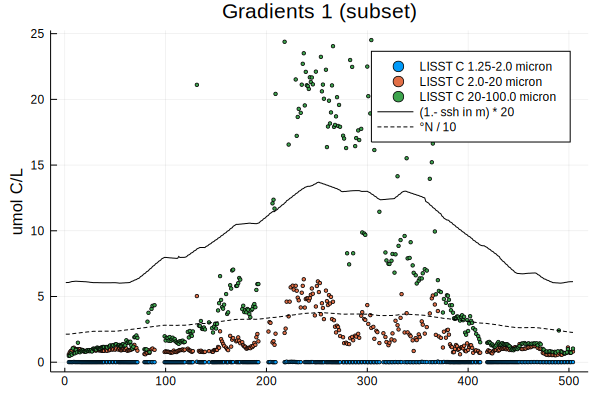

In [8]:
s1=cmap_helpers.get("tblKOK1606_Gradients1_uway_optics","LISST_small")
m1=cmap_helpers.get("tblKOK1606_Gradients1_uway_optics","LISST_medium")
l1=cmap_helpers.get("tblKOK1606_Gradients1_uway_optics","LISST_large")
ssh1=cbiomes_helpers.myinterp(pth,"SSH",s1["lon"],s1["lat"])

t=1:5:length(s1["lat"])
scatter(s1["val"][t],marker = 2,label=s["Long_Name"],
    ylabel=s["Unit"], title="Gradients 1 (subset)")
scatter!(m1["val"][t],marker = 2,label=m["Long_Name"])
scatter!(l1["val"][t],marker = 2,label=l["Long_Name"])
plot!((1.0.-ssh1["val"][t]).*20.0,linecolor=:black,label="(1.- ssh in m) * 20")
plot!(s1["lat"][t]./10.,linecolor=:black,linestyle = :dash,label="°N / 10")

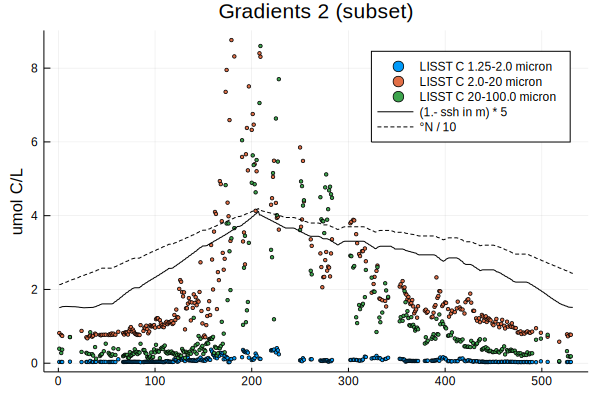

In [9]:
s2=cmap_helpers.get("tblMGL1704_Gradients2_uway_optics","LISST_small")
m2=cmap_helpers.get("tblMGL1704_Gradients2_uway_optics","LISST_medium")
l2=cmap_helpers.get("tblMGL1704_Gradients2_uway_optics","LISST_large")
ssh2=cbiomes_helpers.myinterp(pth,"SSH",s2["lon"],s2["lat"])

t=1:5:length(s2["lat"])
scatter(s2["val"][t],marker = 2,label=s["Long_Name"],
    ylabel=s["Unit"], title="Gradients 2 (subset)")
scatter!(m2["val"][t],marker = 2,label=m["Long_Name"])
scatter!(l2["val"][t],marker = 2,label=l["Long_Name"])
plot!((1.0.-ssh2["val"][t]).*5.0,linecolor=:black,label="(1.- ssh in m) * 5")
plot!(s2["lat"][t]./10.0,linecolor=:black,linestyle = :dash,label="°N / 10")

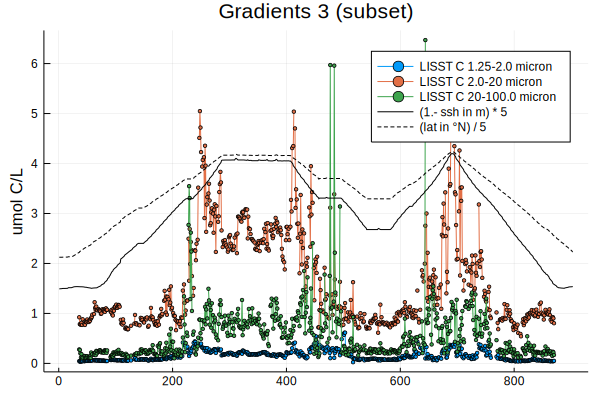

In [10]:
t=1:10:length(s["lat"])
plot(s["val"][t],marker = 2,label=s["Long_Name"],
    ylabel=s["Unit"], title="Gradients 3 (subset)")
plot!(m["val"][t],marker = 2,label=m["Long_Name"])
plot!(l["val"][t],marker = 2,label=l["Long_Name"])
plot!((1.0.-ssh["val"][t]).*5.0,linecolor=:black,label="(1.- ssh in m) * 5")
plot!(s["lat"][t]./10.0,linecolor=:black,linestyle = :dash,label="(lat in °N) / 5")